<a href="https://colab.research.google.com/github/dylanbforde/Cardiac-MRI-Segmentation/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading data

In [2]:
!pip install torchio
!pip install torchinfo
!pip install tensorboard
!pip install monai
!pip install timm
from pathlib import Path
from torch.utils.data import DataLoader
import torchio as tio
import numpy as np
import torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
def get_subjects(image_dir, label_dir):
    image_paths = sorted(image_dir.glob('*.nii.gz'))
    label_paths = sorted(label_dir.glob('*.nii.gz'))
    assert len(image_paths) == len(label_paths)

    subjects = []
    for img_path, lbl_path in zip(image_paths, label_paths):
        subject = tio.Subject(
            mri=tio.ScalarImage(img_path),
            heart=tio.LabelMap(lbl_path)
        )
        subjects.append(subject)
    return subjects

In [4]:
def get_loaders(modality='SA', base_path='/content/drive/Shareddrives/Segmentation Data Split/processed_data', batch_size=4, num_workers=4,
                patch_size=(256, 256, 1), augment=True):

    assert modality in ['SA', 'LA'], "Modality must be 'SA' or 'LA'"

    base_path = Path(base_path)
    paths = {
        'train': {
            'images': base_path / 'train' / modality / 'images',
            'labels': base_path / 'train' / modality / 'labels',
        },
        'val': {
            'images': base_path / 'val' / modality / 'images',
            'labels': base_path / 'val' / modality / 'labels',
        },
        'test': {
            'images': base_path / 'test' / modality / 'images',
            'labels': base_path / 'test' / modality / 'labels',
        }
    }


    # Standardize voxel spacing (in millimeters) BEFORE any spatial aug ---
    # This makes geometry transforms consistent across scans of different resolutions.
    pre = [tio.Resample((1.25, 1.25, 5.0)), ] # (in_plane_x, in_plane_y, slice_thickness)

    # Gentle augmentations applied BEFORE cropping
    # Doing aug before CropOrPad prevents black triangles from rotations/zoom-out
    # and keeps more context during the transform.
    augs = [
        tio.RandomFlip(axes=(0, 1), flip_probability=0.3), # Light in-plane flips. We keep depth (axis=2) unchanged to avoid odd slice reorderings.

        # Very mild affine to avoid destructive distortions
        tio.RandomAffine(
            scales=(1.00, 1.04),          # slight zoom-in only
            degrees=(0, 0, 3),            # in-plane rotation only (about the slice axis)
            translation=(1, 1, 0),        # mm; tiny shifts; 0 along depth to keep slices aligned
            isotropic=False,
            image_interpolation='linear', # smooth images
            label_interpolation='nearest',# keep masks crisp
            p=0.3
        ),

        # Intensity augmentations — gentle, image only.
        # Keep probabilities small so effects don’t stack aggressively.
        tio.RandomNoise(std=(0, 0.01), p=0.2, include=['mri']),
        tio.RandomBiasField(coefficients=0.25, p=0.15, include=['mri']),  # mild B1 inhomogeneity
        tio.RandomGamma(log_gamma=(-0.12, 0.12), p=0.15, include=['mri']),# small contrast variation
    ]



    # Crop/Pad AFTER aug, then normalize
    # Cropping last ensures the patch is centered and free of rotation artifacts.
    # Normalization last gives the network a stable distribution regardless of aug.
    training_transform   = tio.Compose(pre + augs + [
        tio.CropOrPad(patch_size),                                    # center to target patch size
        tio.ZNormalization(masking_method=tio.ZNormalization.mean),]) # normalize non-zero voxels

    # Validation: no aug — just resample, center, normalize.
    validation_transform = tio.Compose(pre + [
        tio.CropOrPad(patch_size),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean),])


    train_subjects = get_subjects(paths['train']['images'], paths['train']['labels'])
    val_subjects = get_subjects(paths['val']['images'], paths['val']['labels'])
    test_subjects = get_subjects(paths['test']['images'], paths['test']['labels'])

    train_dataset = tio.SubjectsDataset(train_subjects, transform=training_transform)
    val_dataset = tio.SubjectsDataset(val_subjects, transform=validation_transform)
    test_dataset = tio.SubjectsDataset(test_subjects, transform=validation_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print("Done")

    return train_loader, val_loader, test_loader

### Data Loader test

In [ ]:
train_loader, val_loader, test_loader = get_loaders(
    modality='SA',
    base_path='/content/drive/Shareddrives/Segmentation Data Split/processed_data',
    batch_size=2,
    num_workers=0,
    patch_size=(256, 256,1),
    augment=True
)

Done


Images shape: torch.Size([2, 1, 256, 256, 1])
Labels shape: torch.Size([2, 1, 256, 256, 1])
Subject keys: dict_keys(['mri', 'heart'])


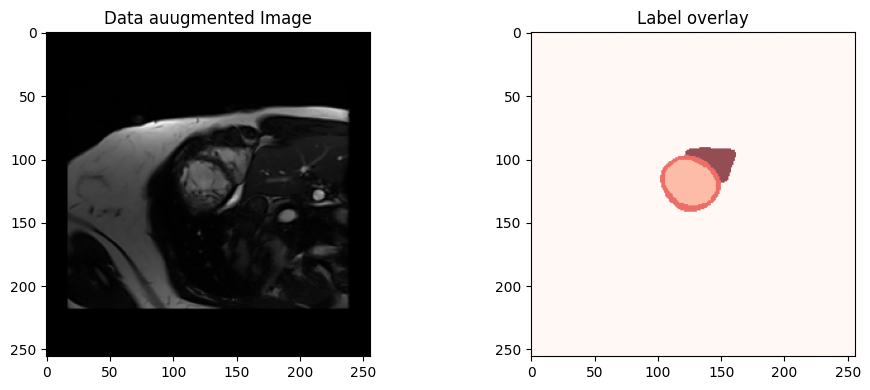

In [ ]:
# This just tests it on a single batch to make sure everthing works

import matplotlib.pyplot as plt

batch = next(iter(train_loader))
images = batch['mri'][tio.DATA]
labels = batch['heart'][tio.DATA]

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Subject keys: {batch.keys()}")

img_slice = images[0, 0, :, :, 0].numpy()
lbl_slice = labels[0, 0, :, :, 0].numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap='gray')
plt.title("Data auugmented Image")

plt.subplot(1, 2, 2)
plt.imshow(lbl_slice, cmap='Reds', alpha=0.7)
plt.title("Label overlay")

plt.tight_layout()
plt.show()

In [ ]:
train_loader, val_loader, test_loader = get_loaders(
    modality='LA',
    base_path='/content/drive/Shareddrives/Segmentation Data Split/processed_data',
    batch_size=2,
    num_workers=0,
    patch_size=(256, 256,1),
    augment=True
)

Done


Images shape: torch.Size([2, 1, 256, 256, 1])
Labels shape: torch.Size([2, 1, 256, 256, 1])
Subject keys: dict_keys(['mri', 'heart'])


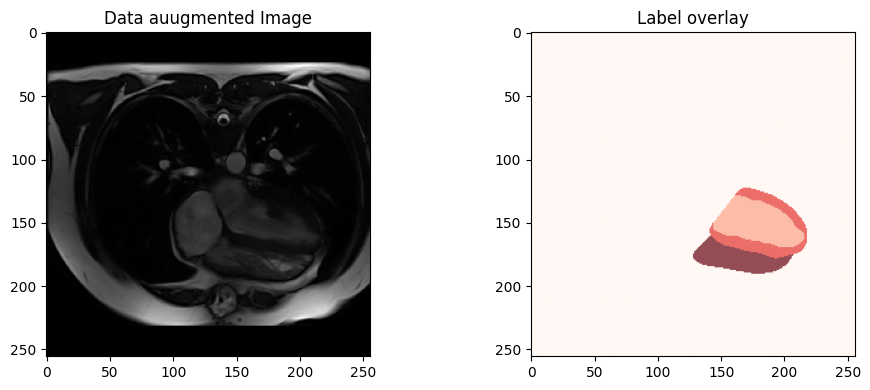

In [ ]:
# This just tests it on a single batch to make sure everthing works

import matplotlib.pyplot as plt

batch = next(iter(train_loader))
images = batch['mri'][tio.DATA]
labels = batch['heart'][tio.DATA]

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Subject keys: {batch.keys()}")

img_slice = images[0, 0, :, :, 0].numpy()
lbl_slice = labels[0, 0, :, :, 0].numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap='gray')
plt.title("Data auugmented Image")

plt.subplot(1, 2, 2)
plt.imshow(lbl_slice, cmap='Reds', alpha=0.7)
plt.title("Label overlay")

plt.tight_layout()
plt.show()

## Model

In [5]:
###################################
#      3D SegFormer Model
###################################

import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.layers import DropPath

# 1. Overlapping Patch Embedding (3D)
class OverlapPatchEmbed3D(nn.Module):
    """
    Splits the input 3D volume into overlapping patches via a Conv3d layer
    and projects them into a token embedding space, followed by LayerNorm.
    """
    def __init__(self, img_size, patch_size, stride, in_chans, embed_dim):
        super().__init__()
        # img_size: (D, H, W), patch_size: (pD, pH, pW), stride: (sD, sH, sW)
        padding = tuple(p // 2 for p in patch_size)
        # 3D convolution to extract patch embeddings
        self.proj = nn.Conv3d(in_chans, embed_dim,
                              kernel_size=patch_size,
                              stride=stride,
                              padding=padding)
        # Layer normalization on the channel dimension
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape [B, C, D, H, W]
        Returns:
            tokens: Tensor of shape [B, N, embed_dim], where N = D'*H'*W'
            spatial_dims: Tuple (D', H', W') after projection
        """
        x = self.proj(x)  # [B, embed_dim, D', H', W']
        B, C, D, H, W = x.shape
        # flatten spatial dims, to [B, N, C]
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x, (D, H, W)

# 2. Transformer Encoder Block
class TransformerBlock(nn.Module):
    """
    A single Transformer block: LayerNorm -> MHSA -> residual -> MLP -> residual.
    Supports stochastic depth via DropPath.
    """
    def __init__(self, dim, num_heads, mlp_ratio=4.0,
                 qkv_bias=True, drop=0.0, attn_drop=0.0, drop_path=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads,
                                          dropout=attn_drop,
                                          bias=qkv_bias)
         # DropPath for stochastic depth regularization
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        # MLP with two linear layers and a GELU activation
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [B, N, C]
        Returns:
            Tensor of shape [B, N, C]
        """
        B, N, C = x.size()
        shortcut = x
        x = self.norm1(x)
        x = x.transpose(0, 1) # MHSA expects sequence-first format [N, B, C]
        x, _ = self.attn(x, x, x)
        x = x.transpose(0, 1)
        x = shortcut + self.drop_path(x) # Residual connection + stochastic depth
        x = x + self.drop_path(self.mlp(self.norm2(x))) # MLP with residual and drop path
        return x

# 3. MiT‑backbone for 3D
class MixTransformer3D(nn.Module):
    """
    Hierarchical Vision Transformer backbone adapted for 3D volumes.
    Consists of multiple stages with overlapping patch embeddings and Transformer blocks.
    """
    def __init__(self,
                 img_size=(1, 256, 256),
                 in_chans=1,
                 embed_dims=[64, 128, 320, 512],
                 num_heads=[1, 2, 5, 8],
                 mlp_ratios=[4, 4, 4, 4],
                 depths=[3, 4, 6, 3],
                 drop_path_rate=0.1):
        super().__init__()
        # Compute drop path schedule across all blocks
        total_blocks = sum(depths)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, total_blocks)]
        cur = 0
        self.stages = nn.ModuleList()
        # Build each stage
        for i in range(len(depths)):
            # Spatial dimensions reduce by patch embed stride
            p_dim = img_size if i == 0 else tuple(max(1, dim // (2 ** i)) for dim in img_size)
            patch_size = (3, 3, 3)
            stride = (2, 2, 1)
            # Input channels for this stage
            in_ch = in_chans if i == 0 else embed_dims[i - 1]
            embed_dim = embed_dims[i]

            patch_embed = OverlapPatchEmbed3D(
                img_size=p_dim,
                patch_size=patch_size,
                stride=stride,
                in_chans=in_ch,
                embed_dim=embed_dim
            )
            # Stack Transformer blocks with scheduled drop path
            blocks = nn.ModuleList()
            for j in range(depths[i]):
                blocks.append(
                    TransformerBlock(
                        dim=embed_dim,
                        num_heads=num_heads[i],
                        mlp_ratio=mlp_ratios[i],
                        drop_path=dpr[cur + j]
                    )
                )
            cur += depths[i]
            # Collect stage modules
            self.stages.append(nn.ModuleList([patch_embed, blocks]))

    def forward(self, x):
        """
        Args:
            x: Input volume [B, C, D, H, W]
        Returns:
            features: List of feature maps from each stage, each of shape [B, C_i, D_i, H_i, W_i]
        """
        features = []
        for patch_embed, blocks in self.stages:
            x, (D, H, W) = patch_embed(x) # Apply patch embedding to get tokens
            for blk in blocks: # Process tokens through transformer blocks
                x = blk(x)
            B, N, C = x.size() # Reshape tokens back into 3D feature map
            feat = x.transpose(1, 2).view(B, C, D, H, W)
            features.append(feat)
            # Use output feature map as input to next stage
            x = feat
        return features

# 4. Decoder for 3D semantic segmentation
class SegFormerDecoder3D(nn.Module):
    """
    Simple MLP-style decoder that projects multi-scale features to a common dimension,
    upsamples them, concatenates, and applies a 1×1 classifier.
    """
    def __init__(self, feature_dims=[64, 128, 320, 512], decoder_dim=256, num_classes=21):
        super().__init__()
        # 1×1×1 convolutions to project each feature map to decoder_dim
        self.proj_layers = nn.ModuleList([
            nn.Conv3d(in_ch, decoder_dim, kernel_size=1)
            for in_ch in feature_dims
        ])
        # Classifier: reduce concatenated features and output num_classes channels
        self.classifier = nn.Sequential(
            nn.Conv3d(decoder_dim * len(feature_dims), decoder_dim, kernel_size=1),
            nn.BatchNorm3d(decoder_dim),
            nn.ReLU(),
            nn.Dropout3d(0.1),
            nn.Conv3d(decoder_dim, num_classes, kernel_size=1)
        )

    def forward(self, features):
        """
        Args:
            features: List of feature tensors from backbone
        Returns:
            logits: Segmentation logits at reduced resolution
        """
        # Determine target spatial resolution from the first feature
        target_size = features[0].shape[2:]
        up_feats = []
        # Project and upsample each feature map
        for feat, proj in zip(features, self.proj_layers):
            f = proj(feat)
            if f.shape[2:] != target_size:
                f = F.interpolate(f, size=target_size, mode='trilinear', align_corners=False)
            up_feats.append(f)
        # Concatenate along channel dimension and classify
        x = torch.cat(up_feats, dim=1)
        return self.classifier(x)

# 5. Full 3D SegFormer
class SegFormer3D(nn.Module):
    """
    Complete SegFormer architecture for 3D volumes: backbone + decoder + final upsampling.
    """
    def __init__(self,
                 img_size=(1, 256, 256),
                 in_chans=1,
                 num_classes=21,
                 decoder_dim=256,
                 **backbone_kwargs):
        super().__init__()
        # Backbone: hierarchical transformer feature extractor
        self.backbone = MixTransformer3D(
            img_size=img_size,
            in_chans=in_chans,
            **backbone_kwargs
        )
        # Decoder: projecting and classifying multi-scale features
        self.decoder = SegFormerDecoder3D(
            feature_dims=backbone_kwargs.get('embed_dims', [64,128,320,512]),
            decoder_dim=decoder_dim,
            num_classes=num_classes
        )

    def forward(self, x):
        """
        Args:
            x: Input tensor [B, C, D, H, W]
        Returns:
            seg_logits: Upsampled segmentation logits [B, num_classes, D, H, W]
        """
        features = self.backbone(x)
        seg = self.decoder(features)
        # Upsample to original resolution
        return F.interpolate(seg, size=x.shape[2:], mode='trilinear', align_corners=False)

In [6]:
# Smaller model configuration
model_config_small = {
    'embed_dims': [32, 64, 160, 256],
    'depths': [2, 2, 2, 2],
    'num_heads': [1, 2, 5, 8],
    'mlp_ratios': [4, 4, 4, 4],
}
model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)
model

SegFormer3D(
  (backbone): MixTransformer3D(
    (stages): ModuleList(
      (0): ModuleList(
        (0): OverlapPatchEmbed3D(
          (proj): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 1), padding=(1, 1, 1))
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): ModuleList(
          (0): TransformerBlock(
            (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (0): Linear(in_features=32, out_features=128, bias=True)
              (1): GELU(approximate='none')
              (2): Linear(in_features=128, out_features=32, bias=True)
              (3): Dropout(p=0.0, inplace=False)
            )
          )
         

### Model test

In [10]:
from torch.nn.functional import softmax
# ================================
#  Minimal Smoke Test for SegFormer3D
# ================================
# This snippet performs a quick validation of the 3D SegFormer model,
# ensuring that it produces outputs with the correct shape and that
# the predicted class probabilities are properly normalized.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
smoke_model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
    ).to(device)

smoke_model.eval()
# Generate a synthetic 5D tensor representing a single 3D volume
# Tensor shape: [batch_size, channels, depth, height, width]
# Here: batch_size=1, channels=1 (grayscale), depth=1, height=256, width=256
with torch.no_grad():
    x = torch.randn(1, 1, 1, 256, 256, device=device)
    logits = smoke_model(x)

# Verify that the output tensor has the expected dimensions:
#    [batch_size, num_classes, depth, height, width]
# For example, if num_classes=3, we expect: [1, 3, 1, 256, 256]
print("Output shape:", logits.shape)

# Apply softmax along the class dimension to obtain probability maps
#    and confirm that probabilities sum to 1 at each voxel.
probs = softmax(logits, dim=1)       # [1, C, D, H, W]
s = probs.sum(dim=1)                 # [1, D, H, W]
print("Sum per voxel min/max:", s.min().item(), s.max().item())

Output shape: torch.Size([1, 1, 1, 256, 256])
Sum per voxel min/max: 1.0 1.0


In [ ]:
# Model architecture visualisation
from torchinfo import summary
summary(
    model,
    input_size=(1,1,1,256,256),
    depth=4,
    col_names=('output_size','num_params'))

Layer (type:depth-idx)                                  Output Shape              Param #
SegFormer3D                                             [1, 1, 1, 256, 256]       --
├─MixTransformer3D: 1-1                                 [1, 32, 1, 128, 256]      --
│    └─ModuleList: 2-1                                  --                        --
│    │    └─ModuleList: 3-1                             --                        --
│    │    │    └─OverlapPatchEmbed3D: 4-1               [1, 32768, 32]            960
│    │    │    └─ModuleList: 4-2                        --                        25,408
│    │    └─ModuleList: 3-2                             --                        --
│    │    │    └─OverlapPatchEmbed3D: 4-3               [1, 16384, 64]            55,488
│    │    │    └─ModuleList: 4-4                        --                        99,968
│    │    └─ModuleList: 3-3                             --                        --
│    │    │    └─OverlapPatchEmbed3D: 4-5      

## Model Training

In [7]:
from monai.metrics import HausdorffDistanceMetric
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torchio.data.image")


def dice_coefficient(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2,3,4))
    union = pred.sum(dim=(2,3,4)) + target.sum(dim=(2,3,4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()



class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0, weight=None, size_average=True):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss(weight=weight, size_average=size_average)

    def forward(self, inputs, targets, smooth=1):
        # Dice Loss
        dice_loss = 1 - dice_coefficient(inputs, targets, smooth)

        # Focal Loss
        bce = self.bce_loss(inputs, targets)
        bce_exp = torch.exp(-bce)
        focal_loss = self.alpha * (1-bce_exp)**self.gamma * bce

        return 2 * dice_loss + focal_loss

def save_model(model, path):
    """Saves the model state dictionary to a file."""
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def train_model(model, train_loader, val_loader, num_epochs=25, learning_rate=1e-4, save_path=None, accumulation_steps=4, early_stopping_patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = CombinedLoss()
    writer = SummaryWriter()


    # Scheduler: reduce LR on validation plateau
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Track and save best validation loss
    best_val = float('inf')
    epochs_no_improve = 0


    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        optimizer.zero_grad()
        for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")):
            images = batch['mri'][tio.DATA].to(device)
            labels = batch['heart'][tio.DATA].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item() * accumulation_steps

        train_loss /= len(train_loader)
        writer.add_scalar('Loss/train', train_loss, epoch)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images = batch['mri'][tio.DATA].to(device)
                labels = batch['heart'][tio.DATA].to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        writer.add_scalar('Loss/val', val_loss, epoch)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Step the LR scheduler
        scheduler.step(val_loss)

        # Save the best model so far
        improved = val_loss < best_val - 1e-6
        if save_path and improved:
            best_val = val_loss
            save_model(model, save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val:.4f}")
            break


    writer.close()
    print("Training finished. Best val loss:", best_val)



In [ ]:
# Get SA and LA data loaders
sa_train_loader, sa_val_loader, sa_test_loader = get_loaders(modality='SA', batch_size=1)
la_train_loader, la_val_loader, la_test_loader = get_loaders(modality='LA', batch_size=1)

# Smaller model configuration
model_config_small = {
    'embed_dims': [32, 64, 160, 256],
    'depths': [2, 2, 2, 2],
    'num_heads': [1, 2, 5, 8],
    'mlp_ratios': [4, 4, 4, 4],
}

# Train the SA model
print("Training SA model...")
sa_model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)
sa_model_save_path = '/content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_sa_small.pth'
train_model(
    sa_model,
    sa_train_loader,
    sa_val_loader,
    num_epochs=50,   ############# epochs number
    learning_rate=1e-4,
    save_path=sa_model_save_path,
    accumulation_steps=4
)

# Train the LA model
print("Training LA model...")
la_model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)
la_model_save_path = '/content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth'
train_model(
    la_model,
    la_train_loader,
    la_val_loader,
    num_epochs=50, ############# epochs number
    learning_rate=1e-4,
    save_path=la_model_save_path,
    accumulation_steps=4
)

Done


/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Done
Training SA model...


Epoch 1/50 [Val]: 100%|██████████| 3275/3275 [57:19<00:00,  1.05s/it]


Epoch 1/50, Train Loss: 1.5729, Val Loss: 1.6254
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_sa_small.pth


Epoch 2/50 [Val]: 100%|██████████| 3275/3275 [03:58<00:00, 13.75it/s]


Epoch 2/50, Train Loss: 1.4991, Val Loss: 1.4030
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_sa_small.pth


Epoch 3/50 [Val]: 100%|██████████| 3275/3275 [03:58<00:00, 13.74it/s]


Epoch 3/50, Train Loss: 1.3737, Val Loss: 1.1732
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_sa_small.pth


Epoch 4/50 [Val]: 100%|██████████| 3275/3275 [03:58<00:00, 13.74it/s]


Epoch 4/50, Train Loss: 1.2403, Val Loss: 1.0873
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_sa_small.pth


Epoch 5/50 [Val]: 100%|██████████| 3275/3275 [03:58<00:00, 13.74it/s]


Epoch 5/50, Train Loss: 1.0761, Val Loss: 0.9511
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_sa_small.pth


Epoch 6/50 [Val]: 100%|██████████| 3275/3275 [03:58<00:00, 13.73it/s]


Epoch 6/50, Train Loss: 0.9676, Val Loss: 0.9162
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_sa_small.pth


Epoch 7/50 [Val]: 100%|██████████| 3275/3275 [03:58<00:00, 13.73it/s]


Epoch 7/50, Train Loss: 0.9253, Val Loss: 0.9387


Epoch 8/50 [Val]: 100%|██████████| 3275/3275 [03:57<00:00, 13.82it/s]


Epoch 8/50, Train Loss: 1.0971, Val Loss: 0.9567


Epoch 9/50 [Val]: 100%|██████████| 3275/3275 [03:57<00:00, 13.81it/s]


Epoch 9/50, Train Loss: 1.0974, Val Loss: 1.2943
Early stopping at epoch 9. Best val loss: 0.9162
Training finished. Best val loss: 0.9161774145968268
Training LA model...


Epoch 1/50 [Val]: 100%|██████████| 288/288 [05:13<00:00,  1.09s/it]


Epoch 1/50, Train Loss: 1.2362, Val Loss: 1.1946
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth


Epoch 2/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.58it/s]


Epoch 2/50, Train Loss: 0.8915, Val Loss: 0.4994
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth


Epoch 3/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.59it/s]


Epoch 3/50, Train Loss: 0.6989, Val Loss: 0.5933


Epoch 4/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.58it/s]


Epoch 4/50, Train Loss: 0.5521, Val Loss: 0.6086


Epoch 5/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.59it/s]


Epoch 5/50, Train Loss: 0.5099, Val Loss: 0.4003
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth


Epoch 6/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.59it/s]


Epoch 6/50, Train Loss: 0.4389, Val Loss: 0.3874
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth


Epoch 7/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.57it/s]


Epoch 7/50, Train Loss: 0.4479, Val Loss: 0.4335


Epoch 8/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.58it/s]


Epoch 8/50, Train Loss: 0.4260, Val Loss: 0.3813
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth


Epoch 9/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.59it/s]


Epoch 9/50, Train Loss: 0.4004, Val Loss: 0.2826
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth


Epoch 10/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.60it/s]


Epoch 10/50, Train Loss: 0.3483, Val Loss: 0.2507
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth


Epoch 11/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.57it/s]


Epoch 11/50, Train Loss: 0.3641, Val Loss: 0.3262


Epoch 12/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.59it/s]


Epoch 12/50, Train Loss: 0.3796, Val Loss: 0.3256


Epoch 13/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.59it/s]


Epoch 13/50, Train Loss: 0.3424, Val Loss: 0.2408
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth


Epoch 14/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.61it/s]


Epoch 14/50, Train Loss: 0.3280, Val Loss: 0.2819


Epoch 15/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.60it/s]


Epoch 15/50, Train Loss: 0.3203, Val Loss: 0.3546


Epoch 16/50 [Val]: 100%|██████████| 288/288 [00:21<00:00, 13.62it/s]

Epoch 16/50, Train Loss: 0.3174, Val Loss: 0.2445
Early stopping at epoch 16. Best val loss: 0.2408
Training finished. Best val loss: 0.24079792688487325


Visualizing predictions for SA model...


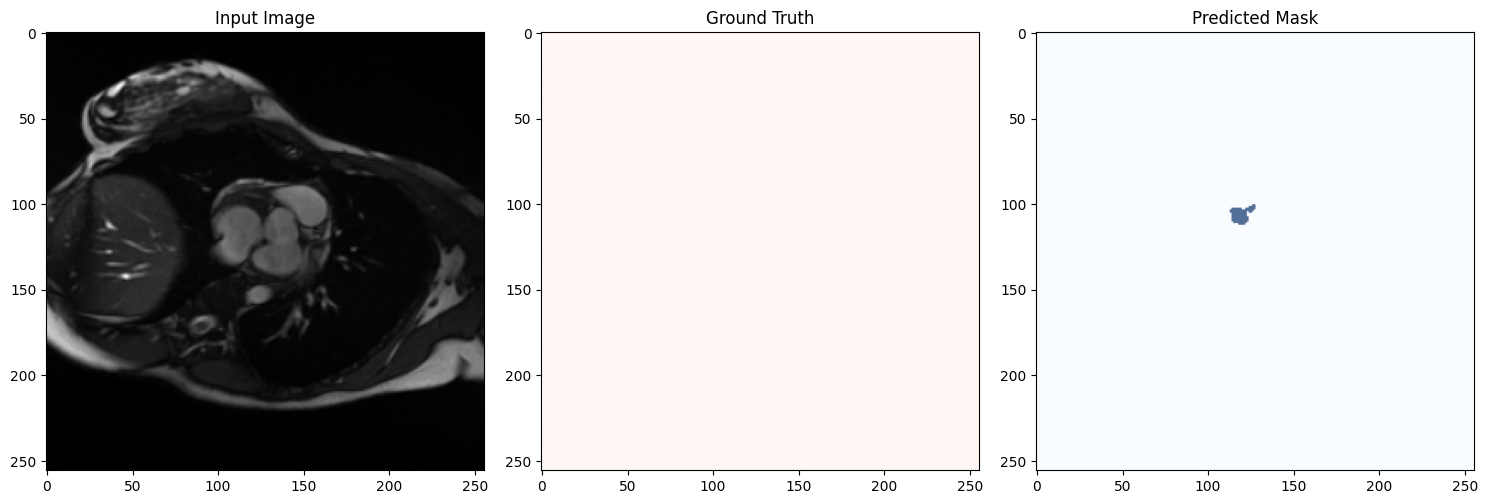

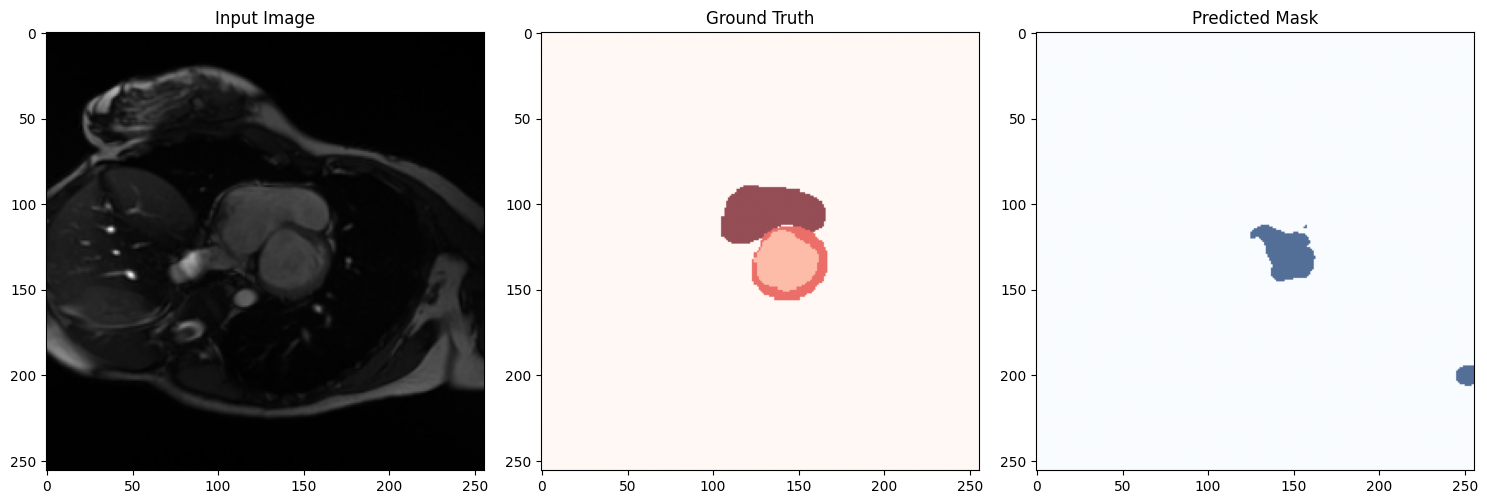

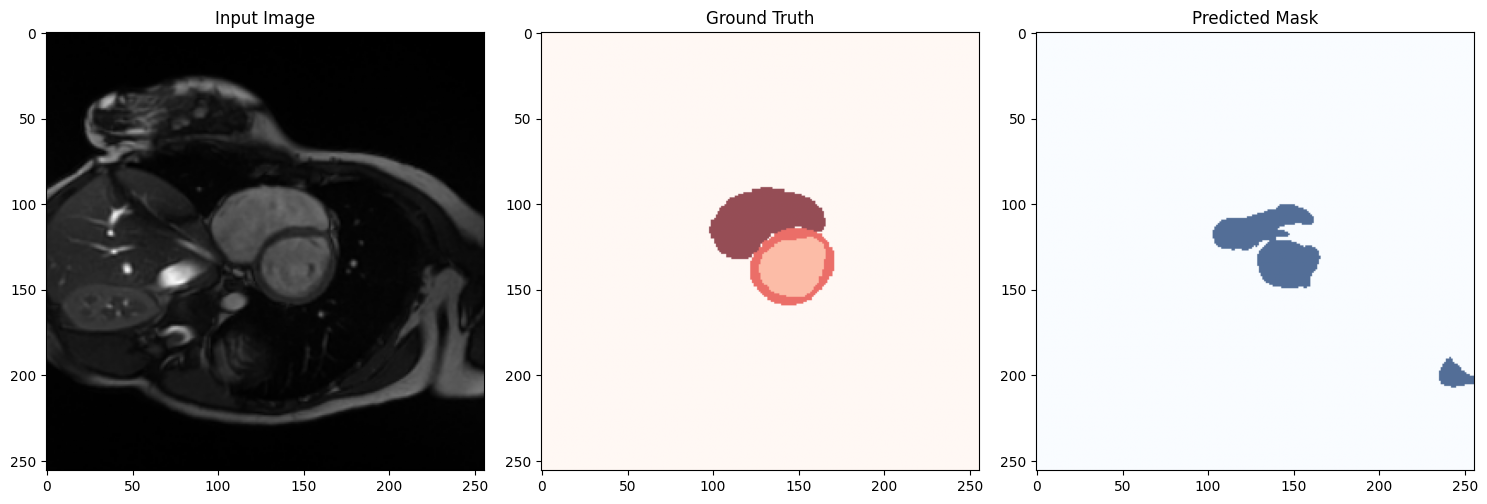


Visualizing predictions for LA model...


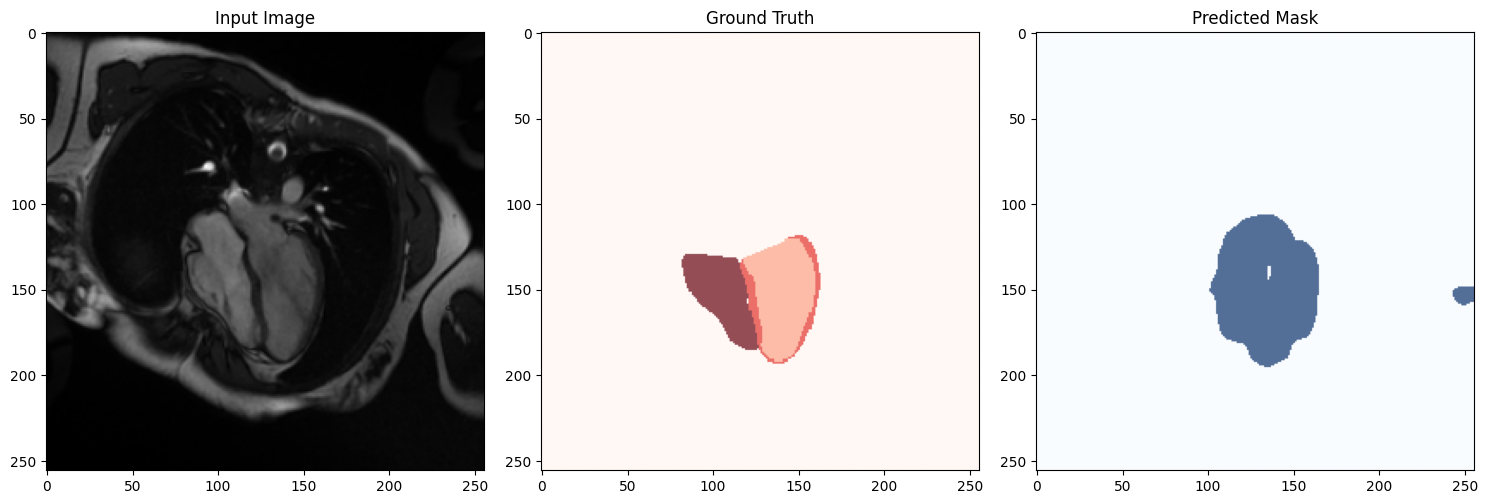

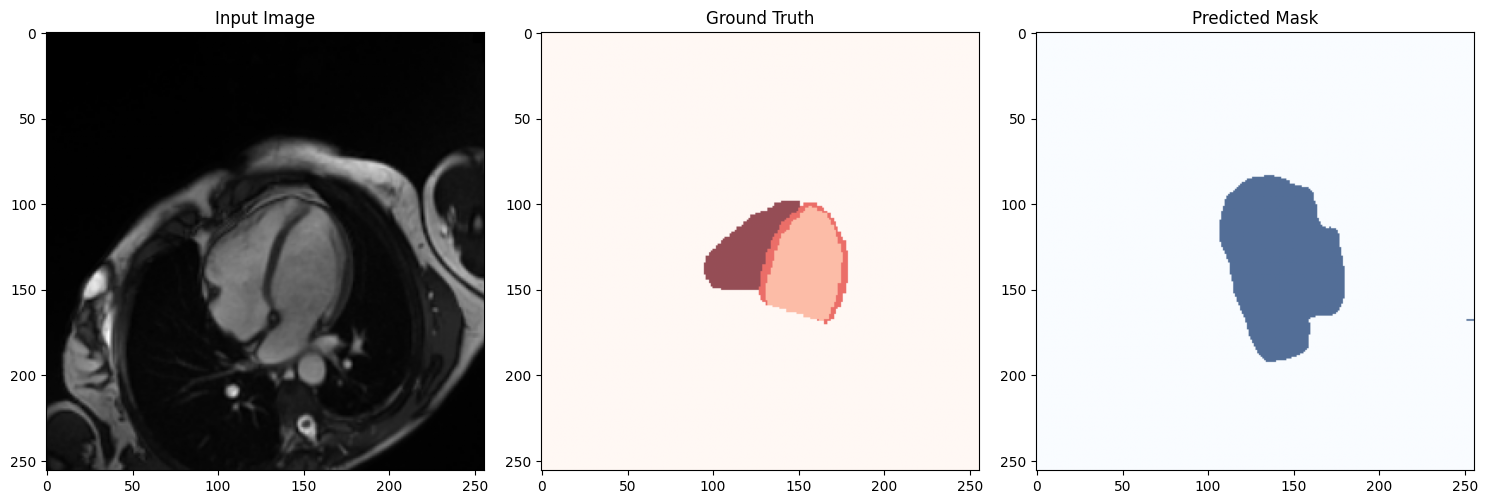

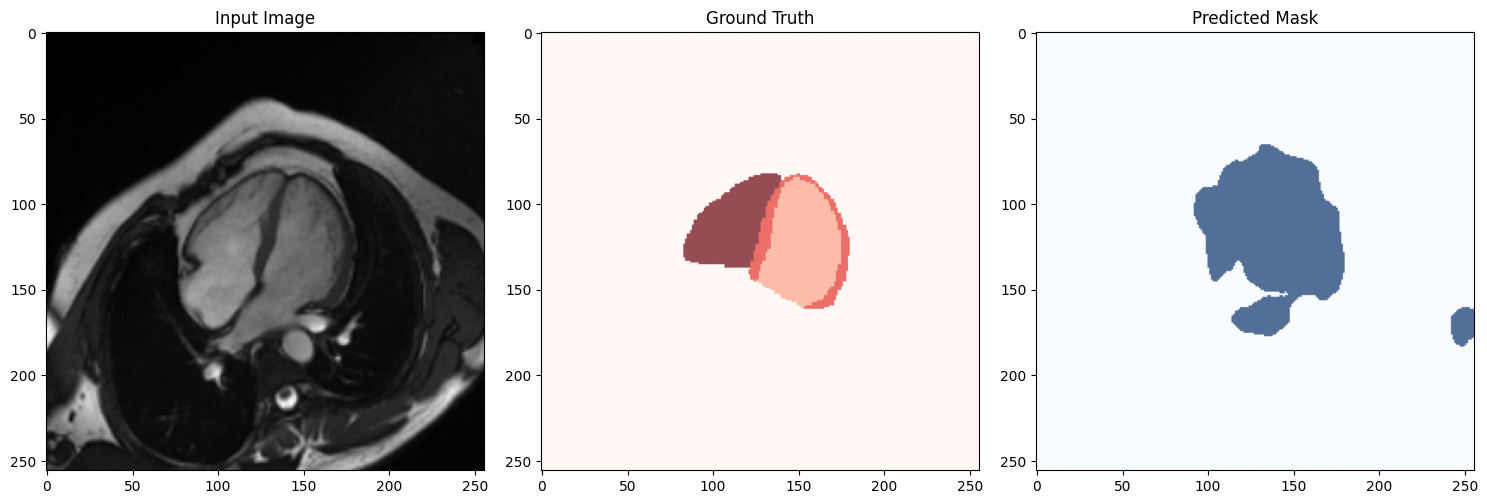

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, loader, num_samples=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= num_samples:
                break

            images = batch['mri'][tio.DATA].to(device)
            labels = batch['heart'][tio.DATA].to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5

            img_slice = images[0, 0, :, :, 0].cpu().numpy()
            lbl_slice = labels[0, 0, :, :, 0].cpu().numpy()
            pred_slice = preds[0, 0, :, :, 0].cpu().numpy()

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(img_slice, cmap='gray')
            plt.title('Input Image')

            plt.subplot(1, 3, 2)
            plt.imshow(lbl_slice, cmap='Reds', alpha=0.7)
            plt.title('Ground Truth')

            plt.subplot(1, 3, 3)
            plt.imshow(pred_slice, cmap='Blues', alpha=0.7)
            plt.title('Predicted Mask')

            plt.tight_layout()
            plt.show()

# Visualize predictions for the SA model on the test set
print("Visualizing predictions for SA model...")
visualize_predictions(sa_model, sa_test_loader)

# Visualize predictions for the LA model on the test set
print("\nVisualizing predictions for LA model...")
visualize_predictions(la_model, la_test_loader)

## Evaluation

In [8]:
import numpy as np
import torch
import torchio as tio
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from monai.metrics import HausdorffDistanceMetric

import warnings
warnings.filterwarnings("ignore", message=".*ground truth of class 0 is all 0.*", category=UserWarning, module="monai")
warnings.filterwarnings("ignore", message=".*prediction of class 0 is all 0.*", category=UserWarning, module="monai")
warnings.filterwarnings("ignore", message=".*get_mask_edges.*", category=FutureWarning, module="monai")


# One global HD95 metric instance (binary segm., ignore background)
hd_metric = HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95)


def test_model(model, test_loader, device, save_csv_path=None, save_model_path=None):
    """
    Evaluate a segmentation model on `test_loader`.

    - All ops run on `device` (typically CUDA). Probabilities -> binary masks via sigmoid + 0.5.
    - Dice is reported using your `dice_coefficient` (it expects logits).
    - Hausdorff distance (HD95) is computed **only** for samples where both GT and prediction
      contain foreground; empty pairs are recorded as NaN and ignored with `np.nanmean`.
    - Precision / Recall / F1 are computed by flattening masks and using sklearn.

    Returns:
        pd.DataFrame with per-sample metrics; also prints dataset-level averages.
    """
    model.eval()

    dice_scores, hausdorff_scores = [], []
    precision_scores, recall_scores, f1_scores = [], [], []
    rows = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Testing")):

            images = batch['mri'][tio.DATA].to(device)
            labels = batch['heart'][tio.DATA].to(device).float()

            # Forward pass (logits) and probability thresholding
            logits = model(images)
            probs  = torch.sigmoid(logits)
            preds  = (probs > 0.5).to(labels.dtype)

            # Dice (your function expects logits; "hard" dice because it thresholds inside)
            current_dice = dice_coefficient(logits, labels).item()
            dice_scores.append(current_dice)

            # Hausdorff (HD95) on device, with per-sample filtering of empty cases
            # Sum over spatial dims only (exclude batch and channels)
            spatial_dims = tuple(range(2, labels.ndim))  # e.g. (2,3,4) for [B,C,D,H,W]
            has_gt   = (labels.sum(dim=spatial_dims) > 0)
            has_pred = (preds.sum(dim=spatial_dims)  > 0)

            # For single-class C==1: squeeze channel -> [B]; else reduce across channels
            valid_mask = (has_gt & has_pred).squeeze(1) if labels.shape[1] == 1 else (has_gt & has_pred).any(dim=1)

            if valid_mask.any():
                # Compute HD only on valid samples; MONAI expects [B, C, ...]
                hd_metric(y_pred=preds[valid_mask], y=labels[valid_mask])
                current_hd = float(hd_metric.aggregate())
                hd_metric.reset()
            else:
                # Undefined when either GT or pred is empty
                current_hd = float('nan')

            hausdorff_scores.append(current_hd)

            # --- Precision / Recall / F1 (sklearn needs CPU NumPy) ---
            y_true = (labels.detach().cpu().numpy() > 0).astype(int).ravel()
            y_pred = (preds.detach().cpu().numpy()  > 0).astype(int).ravel()
            precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
            recall    = recall_score(y_true, y_pred,   average='binary', zero_division=0)
            f1        = f1_score(y_true, y_pred,       average='binary', zero_division=0)

            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

            rows.append({
                'Sample_Index': batch_idx,
                'Dice': current_dice,
                'Hausdorff': current_hd,
                'Precision': precision,
                'Recall': recall,
                'F1': f1
            })

    # --- Averages (HD uses nanmean to ignore NaNs from empty cases) ---
    avg_dice      = float(np.mean(dice_scores)) if dice_scores else 0.0
    avg_hausdorff = float(np.nanmean(hausdorff_scores)) if hausdorff_scores else 0.0
    avg_precision = float(np.mean(precision_scores)) if precision_scores else 0.0
    avg_recall    = float(np.mean(recall_scores)) if recall_scores else 0.0
    avg_f1        = float(np.mean(f1_scores)) if f1_scores else 0.0

    print("\nAverages:")
    print(f"Dice:      {avg_dice:.4f}")
    print(f"Hausdorff: {avg_hausdorff:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall:    {avg_recall:.4f}")
    print(f"F1 Score:  {avg_f1:.4f}")

    # Save per-sample table if requested
    results_df = pd.DataFrame(rows)
    if save_csv_path:
        results_df.to_csv(save_csv_path, index=False)
        print(f"Results saved to {save_csv_path}")

    # Optional: save model weights after evaluation
    if save_model_path:
        save_model(model, save_model_path)

    return results_df


In [11]:
# Get SA and LA data loaders
sa_train_loader, sa_val_loader, sa_test_loader = get_loaders(modality='SA', batch_size=1)
la_train_loader, la_val_loader, la_test_loader = get_loaders(modality='LA', batch_size=1)

# Smaller model configuration
model_config_small = {
    'embed_dims': [32, 64, 160, 256],
    'depths': [2, 2, 2, 2],
    'num_heads': [1, 2, 5, 8],
    'mlp_ratios': [4, 4, 4, 4],
}

# Re-instantiate SA model and load weights
sa_model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)
sa_model.load_state_dict(torch.load('/content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_sa_small.pth'))
sa_model.to(device)
sa_model.eval()  # Set to evaluation mode

# Similarly for LA model
la_model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)

la_model.load_state_dict(torch.load('/content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth'))
la_model.to(device)
la_model.eval()  # Set to evaluation mode

Done
Done


SegFormer3D(
  (backbone): MixTransformer3D(
    (stages): ModuleList(
      (0): ModuleList(
        (0): OverlapPatchEmbed3D(
          (proj): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 1), padding=(1, 1, 1))
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): ModuleList(
          (0): TransformerBlock(
            (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (0): Linear(in_features=32, out_features=128, bias=True)
              (1): GELU(approximate='none')
              (2): Linear(in_features=128, out_features=32, bias=True)
              (3): Dropout(p=0.0, inplace=False)
            )
          )
         

In [12]:
from re import L
# Evaluate SA model
print("Evaluating SA model...")
sa_results = test_model(sa_model, sa_test_loader, device, save_csv_path="sa_results.csv", save_model_path="/content/drive/MyDrive/MIA_assignment2/outputs/sa_small_evaluated.pth")

# Evaluate LA model
print("Evaluating LA model...")
la_results = test_model(la_model, la_test_loader, device, save_csv_path="la_results.csv", save_model_path="/content/drive/MyDrive/MIA_assignment2/outputs/la_small_evaluated.pth")


Evaluating SA model...


Testing: 100%|██████████| 1599/1599 [09:02<00:00,  2.95it/s]



Averages:
Dice:      0.5568
Hausdorff: 76.8162
Precision: 0.4190
Recall:    0.4986
F1 Score:  0.4327
Results saved to sa_results.csv
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/sa_small_evaluated.pth
Evaluating LA model...


Testing: 100%|██████████| 144/144 [01:30<00:00,  1.59it/s]



Averages:
Dice:      0.8964
Hausdorff: 62.4874
Precision: 0.5264
Recall:    0.9197
F1 Score:  0.6547
Results saved to la_results.csv
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/la_small_evaluated.pth
